# Machine Learning and Statistics for Physicists

Material for a [UC Irvine](https://uci.edu/) course offered by the [Department of Physics and Astronomy](https://www.physics.uci.edu/).

Content is maintained on [github](github.com/dkirkby/MachineLearningStatistics) and distributed under a [BSD3 license](https://opensource.org/licenses/BSD-3-Clause).

[Table of contents](Contents.ipynb)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

In [2]:
import scipy.signal

In [3]:
from sklearn import model_selection

In [4]:
import tensorflow as tf

In [5]:
from mls import locate_data

## Neural Network Architectures for Deep Learning

### High-Level Tensorflow APIs

In our earlier examples, we built our networks using [low-level tensorflow primitives](https://www.tensorflow.org/programmers_guide/low_level_intro). For more complex networks composed of standard building blocks, there are convenient higher-level application programming interfaces (APIs) that abstract aways the low-level graphs and sessions.

#### Reading Data

The [tf.data API](https://www.tensorflow.org/programmers_guide/datasets) handles data used to train and test a network, replacing the low-level placeholders we used earlier. For a small dataset that fits in memory, use:
```
dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
```

Creating a Dataset adds nodes to a graph so you should normally wrap your code to create a Dataset in a function that tensorflow will call in the appropriate context. For example, to split the 300 `circles` samples above into train (200) and test (100) datasets:

In [6]:
X = pd.read_hdf(locate_data('circles_data.hf5'))
y = pd.read_hdf(locate_data('circles_targets.hf5'))
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=100, random_state=123)

In [7]:
def get_train_data(batch_size=50):
    dataset = tf.data.Dataset.from_tensor_slices((dict(X_train), y_train))
    return dataset.shuffle(len(X_train)).repeat().batch(batch_size)

In [8]:
def get_test_data(batch_size=50):
    dataset = tf.data.Dataset.from_tensor_slices((dict(X_test), y_test))
    return dataset.batch(batch_size)

While `from_tensor_slices` is convenient, it is not very efficient since the whole dataset is added to the graph with constant nodes (and potentially copied multiple times). Alternatively, convert your data to tensorflow's [binary file format](https://www.tensorflow.org/api_guides/python/python_io) so it can be read as a [TFRecordDataset](https://www.tensorflow.org/api_docs/python/tf/data/TFRecordDataset).

#### Building a Model

The [tf.estimator API](https://www.tensorflow.org/programmers_guide/estimators) builds and runs a graph for training, evaluation and prediction. This API generates a lot of INFO log messages, which can be suppressed using:

In [9]:
tf.logging.set_verbosity(tf.logging.WARN)

First specify the names and types (but not values) of the features that feed the network's input layer:

In [10]:
inputs = [tf.feature_column.numeric_column(key=key) for key in X]

Next, build the network graph. There are [pre-made estimators](https://www.tensorflow.org/programmers_guide/estimators#pre-made_estimators) for standard architectures that are easy to use. For example, to recreate our earlier architecture of a single 4-node hidden layer with sigmoid activation:

In [11]:
config = tf.estimator.RunConfig(
    model_dir='tfs/circle',
    tf_random_seed=123
)

In [12]:
classifier = tf.estimator.DNNClassifier(
    config=config,
    feature_columns=inputs,
    hidden_units=[4],
    activation_fn=tf.sigmoid,
    n_classes=2
)

There are only a limited number of pre-defined models available so you often have to build a [custom estimator](https://www.tensorflow.org/get_started/custom_estimators) using the intermediate-level [layers API](https://www.tensorflow.org/api_docs/python/tf/layers). See convolutional-network example below.

#### Training a Model

An estimator remembers any previous training (using files saved to its `model_dir`) so if you really want to start from scratch you will need to clear this history:

In [13]:
!rm -rf tfs/circle/*

The `train` method runs a specified number of steps (each learning from one batch of training data):

In [14]:
classifier.train(input_fn=get_train_data, steps=5000);

#### Testing a Model

In [15]:
results = classifier.evaluate(input_fn=get_test_data)

In [16]:
results

{'accuracy': 1.0,
 'accuracy_baseline': 0.52999997,
 'auc': 1.0,
 'auc_precision_recall': 1.0,
 'average_loss': 0.10356656,
 'global_step': 5000,
 'label/mean': 0.52999997,
 'loss': 5.178328,
 'prediction/mean': 0.52209604}

### Convolutional Neural Networks

A **convolutional neural network (CNN)** is a special architecture that:
 - Assumes that input features measure some property on a grid. The grid is usually spatial or temporal, but this is not required. For example, a 1D spectrum or time series, a 2D monochrome image, or a 3D stack of 2D images in different filters (RGB, etc).
 - Performs translation-invariant learning efficiently. For example, identifying a galaxy wherever it appears in an image, or a transient pulse wherever it appears in a time series. The main efficiency is a much reduced number of parameters compared to the number of input features, relative to the dense fully connected networks we have seen so far.

We will use the following problem to motivate and demonstration a CNN:
 - The input data consists of triplets of digitized waveforms.
 - Each waveform has a slowly varying level with some narrow pulses superimposed.
 - Each triplet has a single pulse that is synchronized (coincident) in all three waveforms.
 - Waveforms also contain a random number of unsynchronized "background" pulses.
 - Synchronized and unsynchronized pulses can overlap in time and between traces.
 
The goal is to identify the location of the synchronized pulses in each triplet. This is a simplified version of a common task in data acquisition trigger systems and transient analysis pipelines.

In [17]:
def generate(N=10000, ntrace=3, nt=100, nbg=1., A=5., nsmooth=3, T=1., seed=123):
    gen = np.random.RandomState(seed=seed)
    t_grid = np.linspace(0., T, nt)
    # Generate the smooth background shapes as superpositions of random cosines.
    wlen = 2 * T * gen.lognormal(mean=0., sigma=0.2, size=(nsmooth, N, ntrace, 1))
    phase = gen.uniform(size=wlen.shape)
    X = np.cos(2 * np.pi * (t_grid + phase * wlen) / wlen).sum(axis=0)
    # Superimpose short pulses.
    sigma = 0.02 * T
    tsig = T * gen.uniform(0.05, 0.95, size=N)
    y = np.empty(N, dtype=int)
    nbg = gen.poisson(lam=nbg, size=(N, ntrace))
    for i in range(N):
        # Add a coincident pulse to all traces.
        xsig = A * np.exp(-0.5 * (t_grid - tsig[i]) ** 2 / sigma ** 2)
        y[i] = np.argmax(xsig)
        X[i] += xsig
        # Add non-coincident background pulses to each trace.
        for j in range(ntrace):
            if nbg[i, j] > 0:
                t0 = T * gen.uniform(size=(nbg[i, j], 1))
                X[i, j] += (A * np.exp(-0.5 * (t_grid - t0) ** 2 / sigma ** 2)).sum(axis=0)
    return X.astype(np.float32), y
    
X, y = generate()

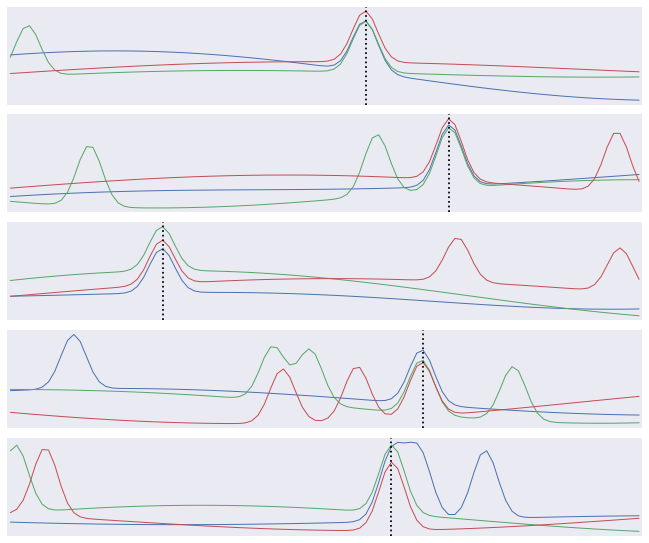

In [18]:
def plot_traces(X, y):
    Nsample, Ntrace, D = X.shape
    _, ax = plt.subplots(Nsample, 1, figsize=(9, 1.5 * Nsample))
    t = np.linspace(0., 1., 100)
    dt = t[1] - t[0]
    for i in range(Nsample):
        for j in range(Ntrace):
            ax[i].plot(t, X[i, j], lw=1)
        ax[i].axvline(t[y[i]], c='k', ls=':')
        ax[i].set_yticks([])
        ax[i].set_xticks([])
        ax[i].set_xlim(-0.5 * dt, 1 + 0.5 * dt)
    plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99, hspace=0.1)
        
plot_traces(X[:5], y[:5])

The derivative of $f(x)$ can be approximated as
$$
f'(x) \simeq \frac{f(x + \delta) - f(x - \delta)}{2\delta}
$$
for small $\delta$. We can use this approximation to convert an array of $f(n \Delta x)$ values into an array of estimated $f'(n \Delta x)$ values using:
```
K = np.array([-1, 0, +1]) / ( 2 * dx)
fp[0] = K.dot(f[[0,1,2]])
fp[1] = K.dot(f[[1,2,3]])
...
fp[N-2] = K.dot(f[[N-3,N-2,N-1]]
```
The numpy [convolve function](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.convolve.html) automates this process of sliding an arbitrary kernel $K$ along an input array like this. The result only estimates a first (or higher-order) derivative when the kernel contains [special values](https://en.wikipedia.org/wiki/Finite_difference_coefficient) (and you should normally use the numpy [gradient function](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.gradient.html) for this), but any convolution is a valid and potentially useful transformation.

The kernel needs to completely overlap the input array it is being convolved with, which means that the output array is smaller and offset. Alternatively, you can pad the input array with zeros to extend the output array. There are three different conventions for handling these edge effects via the `mode` parameter to `np.convolve`:
 - **valid**: no zero padding, so output length is $N - K + 1$ and offset is $(K-1)/2$.
 - **same**: apply zero padding and trim so output length equals input length $N$, and offset is zero.
 - **full**: apply zero padding without trimming, so output length is $N + K - 1$ and offset is $-(K-1)/2$.

(Here $N$ and $K$ are the input and kernel lengths, respectively).

We can use a convolution to identify features in our input data:

In [19]:
def plot_convolved(x, kernel, smax=50):
    t = np.arange(len(x))
    plt.plot(t, x, lw=1, c='gray')
    z = np.convolve(x, kernel, mode='same')
    for sel, c in zip(((z > 0), (z < 0)), 'rb'):
        plt.scatter(t[sel], x[sel], c=c, s=smax * np.abs(z[sel]), lw=0)
    plt.gca()
    plt.grid('off')

First, let's pick out regions of large positive (red) or negative slope (notice how the edge padding causes some artifacts):

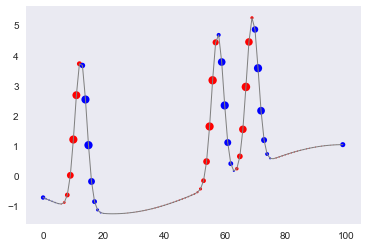

In [20]:
plot_convolved(X[1, 1], [0.5,0,-0.5])

We can also pick out regions of large curvature (using the finite-difference coefficients for a second derivative):

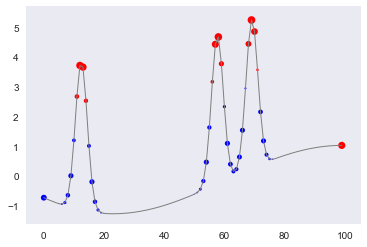

In [21]:
plot_convolved(X[1, 1], [-1.,2.,-1.])

We can apply both of these convolutions to transform our input data to a new representation that highlights regions of large first or second derivative. Use a tanh activation to accentuate the effect:

In [22]:
def apply_convolutions(X, *kernels):
    N1, N2, D = X.shape
    out = []
    for i in range(N1):
        sample = []
        for j in range(N2):
            for K in kernels:
                sample.append(np.tanh(np.convolve(X[i, j], K, mode='valid')))
        out.append(sample)
    return np.asarray(out)

In [23]:
out = apply_convolutions(X, [0.5,0,-0.5], [-1.,2.,-1.])

The resulting array can be viewed as a synthetic image and offers an easy way to visually identify individual narrow peaks and their correlations between traces:

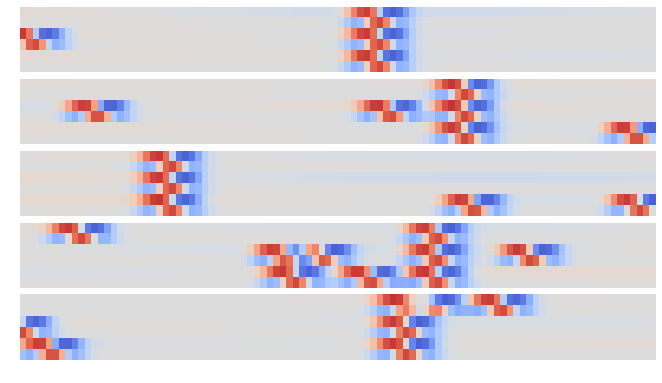

In [24]:
def plot_synthetic(Z):
    _, ax = plt.subplots(len(Z), 1, figsize=(9, len(Z)))
    for i, z in enumerate(Z):
        ax[i].imshow(z, aspect='auto', origin='upper', interpolation='none',
                   cmap='coolwarm', vmin=-1, vmax=+1);
        ax[i].grid('off')
        ax[i].axis('off')
    plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99, hspace=0.1)
    
plot_synthetic(out[:5])

The patterns that identify individual and coincident peaks are all translation invariant so can be identified in this array using a new convolution, but now in the 2D space of these synthetic images.

Since matrix convolution is a linear operation, it is a special case of our general neural network unit,
$$
\mathbf{f}(\mathbf{x}) = W\mathbf{x} + \mathbf{b} \; ,
$$
but with the matrix $W$ now having many repeated elements so its effective number of dimensions is greatly reduced in typical applications.

A **convolutional layer** takes an arbitrary input array and applies a number of filters with the same shape in parallel. By default, the filter kernels march with single-element steps through the input array, but you can also specify larger **stride vector**.

In the general case, the input array, kernels and stride vector are all multidimensional, but with the same dimension. Tensorflow provides convenience functions for 1D, 2D and 3D convolutional layers, for example:
```
hidden = tf.layers.Conv2D(
    filters=3, kernel_size=[4, 5], strides=[2, 1],
    padding='same', activation=tf.nn.relu)
```
Note that `padding` specifies how edges effects are handled, but only `same` and `valid` are supported (and `valid` is the default). You can also implement higher-dimensional convolutional layers using the lower-level APIs.

A **convolutional neural network (CNN)** is a network containing convolutional layers. A typical architecture starts with convolutional layers, processing the input, then finishes with some fully connected dense layers to calculate the output. Since one of the goals of a CNN is reduce the number of parameters, a CNN often also incorporates [pooling layers](https://en.wikipedia.org/wiki/Convolutional_neural_network#Pooling_layer) to reduce the size of the array fed to to later layers by "downsampling" (typically using a maximum or mean value).

In [25]:
def pulse_model(features, labels, mode, params):
    """Build a graph to TRAIN/TEST/PREDICT a pulse coincidence detection model.
    """
    D = params['time_steps']
    M = params['number_of_traces']
    n1 = params['conv1_width']
    n2 = params['conv2_width']
    eta = params['learning_rate']
    assert n1 % 2 == 1 and n2 % 2 == 1

    # Build the input layer.
    inputs = tf.reshape(features['X'], [-1, M, D, 1])
    # Add the first convolutional layer.
    conv1 = tf.layers.conv2d(
        inputs=inputs, filters=2, kernel_size=[1, n1],
        padding='same', activation=tf.tanh)
    # Add the second convolutional (and output) layer.
    logits = tf.layers.conv2d(
        inputs=conv1, filters=1, kernel_size=[M, n2],
        padding='valid', activation=None)
    # Flatten the outputs.
    logits = tf.reshape(logits, [-1, D - n2 + 1])

    # Calculate the offset between input labels and the output-layer node index
    # that is introduced by using padding='valid' for the output layer below.
    offset = (n2 - 1) // 2
    
    # Calculate the network's predicted best label.
    predicted_labels = tf.argmax(logits, axis=1) + offset

    # Calculate the network's predicted probability of each label.
    probs = tf.nn.softmax(logits)
    
    # Calculate the network's predicted mean label.
    bins = tf.range(0., D - n2 + 1., dtype=np.float32) + offset
    mean_labels = tf.reduce_sum(bins * probs, axis=-1)

    # Return predicted labels and probabilities in PREDICT mode.
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions={
            'label': predicted_labels,
            'probs': tf.nn.softmax(logits)
        })
    
    # Calculate the loss for TRAIN and EVAL modes. We need to offset the labels
    # used here so they correspond to output-layer node indices.
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels - offset, logits=logits)
    
    # Compute evaluation metrics.
    if mode == tf.estimator.ModeKeys.EVAL:
        accuracy = tf.metrics.accuracy(labels=labels, predictions=predicted_labels)
        rmse = tf.metrics.root_mean_squared_error(
            labels=tf.cast(labels, np.float32), predictions=mean_labels)
        return tf.estimator.EstimatorSpec(
            mode, loss=loss, eval_metric_ops={'accuracy': accuracy, 'rmse': rmse})
    
    # Create optimizer.
    assert mode == tf.estimator.ModeKeys.TRAIN
    optimizer = tf.train.AdamOptimizer(learning_rate=eta)
    step = optimizer.minimize(loss, global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=step)

In [26]:
tf.logging.set_verbosity(tf.logging.INFO)

In [27]:
!rm -rf tfs/pulses

In [28]:
config = tf.estimator.RunConfig(
    model_dir='tfs/pulses',
    tf_random_seed=123
)

In [29]:
pulse = tf.estimator.Estimator(
    config=config,
    model_fn=pulse_model,
    params = dict(
        time_steps=100,
        number_of_traces=3,
        conv1_width=3,
        conv2_width=7,
        learning_rate=0.01))

INFO:tensorflow:Using config: {'_model_dir': 'tfs/pulses', '_tf_random_seed': 123, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c1f5520f0>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [30]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.4, random_state=123)

In [31]:
pulse.train(
    input_fn=tf.estimator.inputs.numpy_input_fn(
        x={'X': X_train}, y=y_train,
        batch_size=500, num_epochs=None, shuffle=True),
    steps=500);

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into tfs/pulses/model.ckpt.
INFO:tensorflow:loss = 4.61124, step = 1
INFO:tensorflow:global_step/sec: 61.9922
INFO:tensorflow:loss = 0.364795, step = 101 (1.614 sec)
INFO:tensorflow:global_step/sec: 63.9277
INFO:tensorflow:loss = 0.251504, step = 201 (1.564 sec)
INFO:tensorflow:global_step/sec: 62.2952
INFO:tensorflow:loss = 0.189344, step = 301 (1.605 sec)
INFO:tensorflow:global_step/sec: 62.7627
INFO:tensorflow:loss = 0.173071, step = 401 (1.593 sec)
INFO:tensorflow:Saving checkpoints for 500 into tfs/pulses/model.ckpt.
INFO:tensorflow:Loss for final step: 0.139731.


In [32]:
results = pulse.evaluate(
    input_fn=tf.estimator.inputs.numpy_input_fn(
        x={'X': X_test}, y=y_test,
        num_epochs=1, shuffle=False))

INFO:tensorflow:Starting evaluation at 2018-03-18-22:18:54
INFO:tensorflow:Restoring parameters from tfs/pulses/model.ckpt-500
INFO:tensorflow:Finished evaluation at 2018-03-18-22:18:55
INFO:tensorflow:Saving dict for global step 500: accuracy = 0.94575, global_step = 500, loss = 0.150648, rmse = 0.403055


In [33]:
results

{'accuracy': 0.94575,
 'global_step': 500,
 'loss': 0.15064813,
 'rmse': 0.40305537}

INFO:tensorflow:Restoring parameters from tfs/pulses/model.ckpt-500


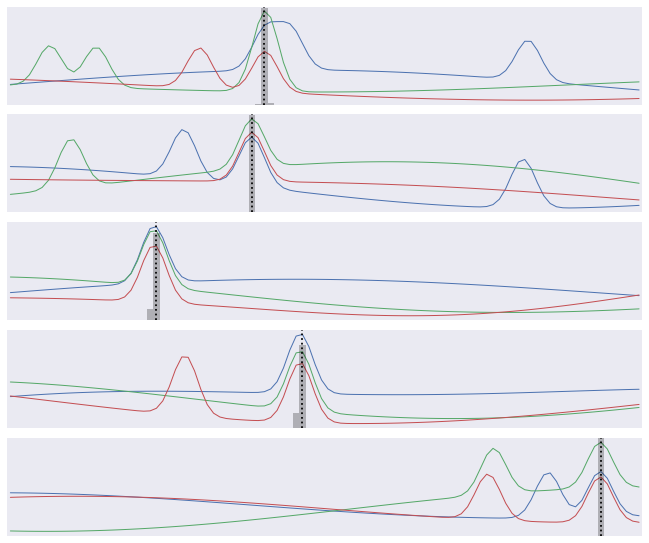

In [34]:
def plot_predictions(X, y):
    # Calculate predicted labels and PDFs over labels.
    predictions = pulse.predict(
        input_fn=tf.estimator.inputs.numpy_input_fn(
            x={'X': X}, y=None, num_epochs=1, shuffle=False))    
    Nsample, Ntrace, D = X.shape
    t = np.linspace(0., 1., 100)
    dt = t[1] - t[0]
    bins = np.linspace(-0.5 * dt, 1 + 0.5 * dt, len(t) + 1)
    probs = np.zeros(D)
    # Plot input data, truth, and predictions.
    _, ax = plt.subplots(Nsample, 1, figsize=(9, 1.5 * Nsample))
    for i, pred in enumerate(predictions):
        label = pred['label']
        # Plot the input traces.
        for x in X[i]:
            ax[i].plot(t, x, lw=1)
        # Indicate the true coincidence position.
        ax[i].axvline(t[y[i]], c='k', ls=':')
        # Indicate the predicted probability distribution.
        n2 = D - len(pred['probs']) + 1
        offset = (n2 - 1) // 2
        probs[offset:-offset] = pred['probs']
        rhs = ax[i].twinx()
        rhs.hist(t, weights=probs, bins=bins, histtype='stepfilled', alpha=0.25, color='k')
        rhs.set_ylim(0., 1.)
        rhs.set_xlim(bins[0], bins[-1])
        rhs.set_yticks([])
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].grid('off')
        ax[i].set_xlim(bins[0], bins[-1])
    plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99, hspace=0.1)
        
plot_predictions(X_test[:5], y_test[:5])

Note that our loss function does not know that consecutive labels are close and being off by one is almost as good as getting the right label. We could change this by treating this as a regression problem, but a nice feature of our multi-category approach is that we can predict a a full probability density over labels (the gray histograms above) which is often useful.

## Encoder and Decoder Networks

Neural networks are usually used for supervised learning since their learning is accomplished by optimizing a loss function that compares the network's outputs with some target values. However, it is possible to perform unsupervised learning if we can somehow use the same data for both the input values and the target output values. This requires that the network have the same number of input and output nodes, and effectively means that we are asking it to learn the identify function, which does not sound obviously useful.

Suppose we have a single hidden layer with the same number of nodes as the input and output layers, then all the network has to do is pass each input value through to the output, which does not require any training at all!  However, if the hidden layer has fewer nodes then we are asking the network to solve a more interesting problem: how can the input dataset be encoded and then decoded. This is the same **dimensionality reduction** problem we discussed [earlier](Dimensionality.ipynb).

In [36]:
X = pd.read_hdf(locate_data('spectra_data.hf5'))